# Homework03: Explore CNN algorithms for protein 2D contact structure predictionHomework03: Explore CNN algorithms for protein 2D contact structure prediction

In [ ]:
#@title Data preparation: get (L, L, 4)


import numpy as np
import pandas as pd
import zipfile

X_train = []
y_train = []

with zipfile.ZipFile("homework3_train.zip", 'r') as zip_ref:
    for file_name in zip_ref.namelist():
      if file_name.endswith('.pkl'):
        with zip_ref.open(file_name) as pkl_file:
          df = pd.read_pickle(pkl_file)
          X_train.append(df)

      if file_name.endswith('.npy'):
        with zip_ref.open(file_name) as npy_file:
          y_train.append(np.load(npy_file, allow_pickle=True))

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
import numpy as np
import pandas as pd
import zipfile

X_test = []
y_test = []

with zipfile.ZipFile("homework3_test.zip", 'r') as zip_ref:
    for file_name in zip_ref.namelist():
      if file_name.endswith('.pkl'):
        with zip_ref.open(file_name) as pkl_file:
          df = pd.read_pickle(pkl_file)
          X_test.append(df)

      if file_name.endswith('.npy'):
        with zip_ref.open(file_name) as npy_file:
          y_test.append(np.load(npy_file, allow_pickle=True))

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# Determine the maximum sequence length using the distance maps (assumed to be at index 2)
max_length = max(y[2].shape[0] for y in y_train)
print("Maximum sequence length:", max_length)

y_train_processed = []

for i in range(len(y_train)):
    # Extract the distance map for the i-th protein
    distance_map = y_train[i][2]
    seq_length = distance_map.shape[0]

    # Create a contact map using a threshold of 8, ignoring self-contacts (diagonal)
    mask = (distance_map < 8) & (np.eye(seq_length) == 0)
    contact_map = distance_map.copy()
    contact_map[mask] = 1
    contact_map[~mask] = 0

    # Pad the contact map to shape (max_length, max_length)
    pad_width = ((0, max_length - seq_length), (0, max_length - seq_length))
    padded_contact_map = np.pad(contact_map, pad_width=pad_width, mode='constant', constant_values=0)

    y_train_processed.append(padded_contact_map)

Maximum sequence length: 149


In [ ]:
# Determine the maximum sequence length using the distance maps
max_length = max(y[2].shape[0] for y in y_test)
print("Maximum sequence length:", max_length)

y_test_processed = []

for i in range(len(y_test)):
    # Extract the distance map for the i-th protein
    distance_map = y_test[i][2]
    seq_length = distance_map.shape[0]

    # Create a contact map using a threshold of 8
    mask = (distance_map < 8) & (np.eye(seq_length) == 0)
    contact_map = distance_map.copy()
    contact_map[mask] = 1
    contact_map[~mask] = 0

    # Pad the contact map to shape (max_length, max_length)
    pad_width = ((0, max_length - seq_length), (0, max_length - seq_length))
    padded_contact_map = np.pad(contact_map, pad_width=pad_width, mode='constant', constant_values=0)

    y_test_processed.append(padded_contact_map)

Maximum sequence length: 149


In [ ]:
y_train_processed = np.array(y_train_processed)
y_test_processed = np.array(y_test_processed)

print(y_train_processed.shape)
print(y_test_processed.shape)

(500, 149, 149)
(100, 149, 149)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_processed, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test_processed.shape)

(400,)
(100,)
(100,)
(400, 149, 149)
(100, 149, 149)
(100, 149, 149)


In [ ]:
def extract_features(data):
  features = []

  L = len(data['seq'])
  features = np.zeros((L, L, 4), dtype=np.float32)

  if 'ss' in data:
    features[:, :, 0] = np.tile(data['ss'][0], (L, 1))

  if 'sa' in data:
    features[:, :, 1] = np.tile(data['sa'], (L, 1))

  if 'ccmpred' in data:
    features[:, :, 2] = data['ccmpred']

  if 'freecon' in data:
    features[:, :, 3] = data['freecon']

  features = np.array(features)

  return features

In [ ]:
X_train_features = [extract_features(data) for data in X_train]
X_val_features = [extract_features(data) for data in X_val]
X_test_features = [extract_features(data) for data in X_test]

In [ ]:
# Determine the maximum protein sequence length
max_length = max(features.shape[0] for features in X_train_features)
print("Maximum protein length:", max_length)

def pad_protein_features(features, max_length):
    L = features.shape[0]
    # Pad rows and columns so the array becomes (max_length, max_length, 4)
    pad_width = ((0, max_length - L),
                 (0, max_length - L),
                 (0, 0))
    return np.pad(features, pad_width=pad_width, mode='constant', constant_values=0)

# Pad each protein's feature array
X_train_padded = [pad_protein_features(features, max_length) for features in X_train_features]

# stack them into one array
X_train_padded = np.stack(X_train_padded)
print("Shape of padded X_train:", X_train_padded.shape)

# Pad each protein's feature array
X_val_padded = [pad_protein_features(features, max_length) for features in X_val_features]

# stack them into one array
X_val_padded = np.stack(X_val_padded)
print("Shape of padded X_val:", X_val_padded.shape)

# Pad each protein's feature array
X_test_padded = [pad_protein_features(features, max_length) for features in X_test_features]

# stack them into one array
X_test_padded = np.stack(X_test_padded)
print("Shape of padded X_test:", X_test_padded.shape)

Maximum protein length: 149
Shape of padded X_train: (400, 149, 149, 4)
Shape of padded X_val: (100, 149, 149, 4)
Shape of padded X_test: (100, 149, 149, 4)


# CNN Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the custom CNN model
input_shape = (149, 149, 4)  # Input shape for protein data

inputs = layers.Input(shape=input_shape)

# Convolutional Block 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

# Convolutional Block 2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

# Output layer
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Build the model
CNN_model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 149, 149, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 149, 149, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 149, 149, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 149, 149, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 149, 149, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 149, 149, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 149, 149, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 149, 149, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 149, 149, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 149, 149, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Train the model
history = CNN_model.fit(
    X_train_padded, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_val_padded, y_val)
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.7010 - loss: 0.6993 - val_accuracy: 0.9601 - val_loss: 0.4289
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9553 - loss: 0.3831 - val_accuracy: 0.9600 - val_loss: 0.2362
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9654 - loss: 0.2425 - val_accuracy: 0.9599 - val_loss: 0.1763
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9655 - loss: 0.1813 - val_accuracy: 0.9604 - val_loss: 0.1614
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9671 - loss: 0.1571 - val_accuracy: 0.9606 - val_loss: 0.1559
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9663 - loss: 0.1519 - val_accuracy: 0.9608 - val_loss: 0.1519
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9662 - loss: 0.1432 - val_accuracy: 0.9622 - val_loss: 0.1484
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9671 - loss: 0.1365 - val_accuracy: 0.9631 - 

In [ ]:
# Evaluate the model
loss, accuracy = CNN_model.evaluate(X_val_padded, y_val, verbose=0)
print("Validation Loss: {:.4f}".format(loss))
print("Validation Accuracy: {:.4f}".format(accuracy))

Validation Loss: 0.1200
Validation Accuracy: 0.9686


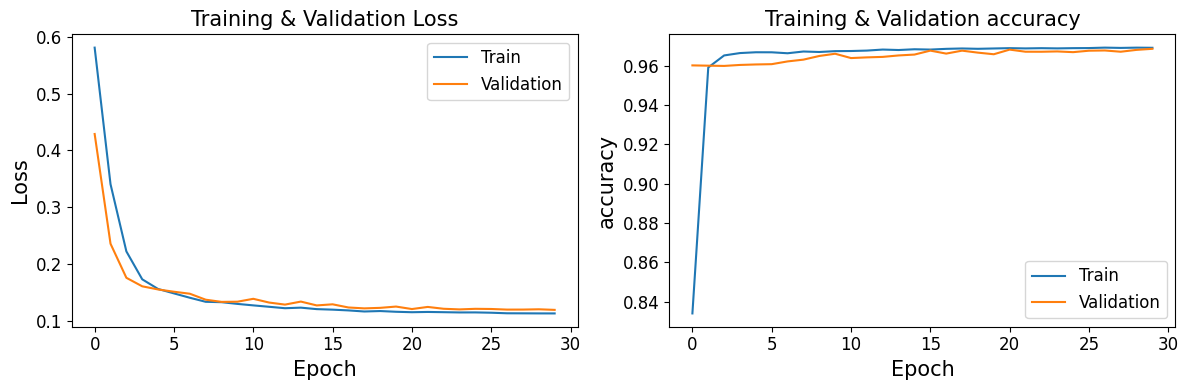

In [ ]:
from matplotlib import pyplot as plt

# Visualize the learning curves during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='upper right', fontsize=12)

plt.subplot(1,2,2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training & Validation accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

# ResNet50V2 Model

In [ ]:
import numpy as np
import tensorflow as tf

def process_inputs(data, target_size=(224, 224)):
    """

    Processes a batch of images by combining the last two channels and resizing.

    """
    # If the data is a NumPy array, convert to a TensorFlow tensor.
    if isinstance(data, np.ndarray):
        data = tf.convert_to_tensor(data)

    # Combine the 3rd and 4th channels by taking their average.
    combined_channel = tf.reduce_mean(data[..., 2:4], axis=-1, keepdims=True)

    # Keep the first two channels as they are, and concatenate with the combined channel.
    new_data = tf.concat([data[..., 0:2], combined_channel], axis=-1)

    # Resize all images to the target size.
    resized_data = tf.image.resize(new_data, target_size)

    return resized_data

# Process each dataset.
X_train_processed = process_inputs(X_train_padded)
X_val_processed   = process_inputs(X_val_padded)
X_test_processed  = process_inputs(X_test_padded)

print("X_train_processed shape:", X_train_processed.shape)
print("X_val_processed shape:", X_val_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

X_train_processed shape: (400, 224, 224, 3)
X_val_processed shape: (100, 224, 224, 3)
X_test_processed shape: (100, 224, 224, 3)


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Load ResNet50V2 with correct input shape (224x224)
resnet_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Ensure the convolutional base is trainable
resnet_base.trainable = True

# build the model on top of the resnet base
model = Sequential()
model.add(resnet_base)
model.add(Lambda(lambda t: tf.image.resize(t, (149, 149))))
model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 149, 149, 2048)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 149, 149, 1)         │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 23,521,409 (89.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
import tensorflow as tf
import numpy as np

def data_generator(X, y, batch_size):
    """

    Generator that yields batches of (inputs, labels).

    """
    num_samples = X.shape[0]
    while True:
        # Create shuffled indices as a NumPy array, then convert to a TensorFlow tensor
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        # Use tf.gather to index the tensor with the shuffled indices
        X_shuffled = tf.gather(X, indices)
        y_shuffled = tf.gather(y, indices)

        for offset in range(0, num_samples, batch_size):
            batch_X = X_shuffled[offset:offset + batch_size]
            batch_y = y_shuffled[offset:offset + batch_size]
            yield batch_X, batch_y


batch_size = 8

train_gen = data_generator(X_train_processed, y_train, batch_size)
val_gen   = data_generator(X_val_processed, y_val, batch_size)
test_gen = data_generator(X_test_processed, y_test_processed, batch_size)

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=X_train_processed.shape[0] // batch_size,
    validation_data=val_gen,
    validation_steps=X_val_processed.shape[0] // batch_size,
    epochs=10
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 362ms/step - accuracy: 0.7357 - loss: 0.5171 - val_accuracy: 0.9456 - val_loss: 0.2405
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 0.9572 - loss: 0.1499 - val_accuracy: 0.9562 - val_loss: 0.1847
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.9593 - loss: 0.1331 - val_accuracy: 0.9556 - val_loss: 0.1682
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step - accuracy: 0.9600 - loss: 0.1262 - val_accuracy: 0.9578 - val_loss: 0.1543
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.9594 - loss: 0.1247 - val_accuracy: 0.9558 - val_loss: 0.1537
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - accuracy: 0.9592 - loss: 0.1246 - val_accuracy: 0.9578 - val_loss: 0.1459
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - accuracy: 0.9587 - loss: 0.1254 - val_accuracy: 0.9559 - val_loss: 0.1541
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - accuracy: 0.9590 - loss: 0.1232 - val_accu

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val_processed, y_val, verbose=0)
print("Validation Loss: {:.4f}".format(loss))
print("Validation Accuracy: {:.4f}".format(accuracy))

Validation Loss: 0.1489
Validation Accuracy: 0.9563


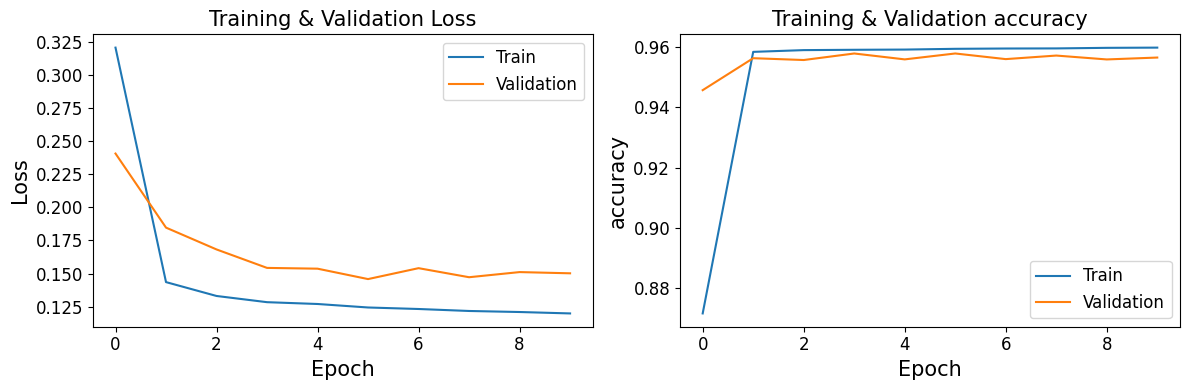

In [ ]:
from matplotlib import pyplot as plt

# Visualize the learning curves during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='upper right', fontsize=12)

plt.subplot(1,2,2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training & Validation accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

#Evaluation



In [ ]:
from re import X
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define threshold for classification
threshold = 0.3

# Function to apply threshold and calculate metrics
def evaluate_model(model, X_data, y_true, dataset_name):
    # Get predicted probabilities from the model
    y_pred_probs = model.predict(X_data)

    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_probs > threshold).astype(int)

    # Flatten the arrays to use with accuracy_score
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)

    # Print results
    print(f"Metrics for {dataset_name} set using CNN_model:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 50)

In [ ]:
# Evaluate on the training set
evaluate_model(CNN_model, X_train_padded, y_train, "Training")

# Evaluate on the validation set
evaluate_model(CNN_model, X_val_padded, y_val, "Validation")

# Evaluate on the testing set
evaluate_model(CNN_model, X_test_padded, y_test_processed, "Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step
Metrics for Training set using CNN_model:
Accuracy: 0.9668
Precision: 0.6182
Recall: 0.5109
F1-score: 0.5594
--------------------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Metrics for Validation set using CNN_model:
Accuracy: 0.9649
Precision: 0.6146
Recall: 0.4951
F1-score: 0.5484
--------------------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Metrics for Test set using CNN_model:
Accuracy: 0.9690
Precision: 0.6323
Recall: 0.5231
F1-score: 0.5725
--------------------------------------------------


In [ ]:
def evaluate_model_with_generator(model, data_gen, dataset_name, steps):
    all_preds = []
    all_trues = []

    # Iterate over the number of steps to cover the entire dataset
    for step in range(steps):
        # Get a batch from the generator
        X_data, y_true = next(data_gen)

        # Get predicted probabilities from the model
        y_pred_probs = model.predict(X_data, verbose=0)

        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_pred_probs > threshold).astype(int)

        # Accumulate predictions and ground truths
        all_preds.extend(np.array(y_pred).flatten())
        all_trues.extend(np.array(y_true).flatten())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_trues = np.array(all_trues)

    # Calculate metrics
    accuracy = accuracy_score(all_trues, all_preds)
    precision = precision_score(all_trues, all_preds)
    recall = recall_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds)

    # Print results
    print(f"Metrics for {dataset_name} set using Resnet50V2 Model:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 50)

    # set batch size
    batch_size = 8

# calculate the number of steps for each evaluation
steps_train = math.ceil(X_train_processed.shape[0] / batch_size)
steps_val   = math.ceil(X_val_processed.shape[0] / batch_size)
steps_test  = math.ceil(X_test_processed.shape[0] / batch_size)

# Evaluate on the training set
evaluate_model_with_generator(model, train_gen, "Training", steps_train)

# Evaluate on the validation set
evaluate_model_with_generator(model, val_gen, "Validation", steps_val)

# Evaluate on the testing set
evaluate_model_with_generator(model, test_gen, "Test", steps_test)

Metrics for Training set using Resnet50V2 Model:
Accuracy: 0.9497
Precision: 0.3726
Recall: 0.3184
F1-score: 0.3434
--------------------------------------------------
Metrics for Validation set using Resnet50V2 Model:
Accuracy: 0.9464
Precision: 0.3211
Recall: 0.2422
F1-score: 0.2761
--------------------------------------------------
Metrics for Test set using Resnet50V2 Model:
Accuracy: 0.9524
Precision: 0.3527
Recall: 0.2419
F1-score: 0.2869
--------------------------------------------------


#VGG16



Report the final accuracy, F1-score, Precision, Recall on training, validation, and testing dataset using VGG16.

uses same 224x224x3 input shape

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top layer (fully connected layers)
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers (you can also fine-tune them)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for contact map prediction
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(149 * 149, activation='sigmoid')(x)  # 149x149 grid for binary contact prediction
x = layers.Reshape((149, 149))(x)  # Reshape to match the 2D grid output

# Create the final model
model_vgg = models.Model(inputs=base_model.input, outputs=x)

# Compile the model with binary crossentropy loss and an optimizer
model_vgg.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_vgg.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 20,814,329 (79.40 MB)

 Trainable params: 6,099,641 (23.27 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model_vgg.fit(X_train_processed, y_train, epochs=30, batch_size=8)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0340 - loss: 0.3399
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.0243 - loss: 0.0972
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.0305 - loss: 0.0961
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.0312 - loss: 0.0981
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.0300 - loss: 0.0966
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.0316 - loss: 0.0968
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.0314 - loss: 0.0985
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.0316 - loss: 0.0954
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.0319 - loss: 0.0983
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.0319 - loss: 0.0991
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.0320 - loss: 0.0974
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define threshold for classification
threshold = 0.3

# Function to apply threshold and calculate metrics
def evaluate_model(model, X_data, y_true, dataset_name):
    # Get predicted probabilities from the model
    y_pred_probs = model.predict(X_data)

    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_probs > threshold).astype(int)

    # Flatten the arrays to use with accuracy_score
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)

    # Print results
    print(f"Metrics for {dataset_name} set using {model.name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 50)

# Example of how to evaluate multiple models:
models = [
    (model_vgg, "VGG16")

]

for model, name in models:
    # Assign a name to each model explicitly
    model.name = name

    # Evaluate on the training set
    evaluate_model(model, X_train_processed, y_train, "Training")

    # Evaluate on the validation set
    evaluate_model(model, X_val_processed, y_val, "Validation")

    # Evaluate on the testing set
    evaluate_model(model, X_test_processed, y_test_processed, "Test")


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 849ms/step
Metrics for Training set using VGG16:
Accuracy: 0.9689
Precision: 0.6347
Recall: 0.5796
F1-score: 0.6059
--------------------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Metrics for Validation set using VGG16:
Accuracy: 0.9657
Precision: 0.6159
Recall: 0.5381
F1-score: 0.5744
--------------------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
Metrics for Test set using VGG16:
Accuracy: 0.9690
Precision: 0.6143
Recall: 0.5856
F1-score: 0.5996
--------------------------------------------------


**PART** II- task4

In [ ]:
def extract_two_features(data):
  features = []

  L = len(data['seq'])
  features = np.zeros((L, L, 2), dtype=np.float32)

  if 'ss' in data:
    features[:, :, 0] = np.tile(data['ss'][0], (L, 1))

  if 'sa' in data:
    features[:, :, 1] = np.tile(data['sa'], (L, 1))

  features = np.array(features)

  return features

In [ ]:
print(extract_two_features(X_train[0]).shape)

(146, 146, 2)


In [ ]:
X_train_two_features = [extract_two_features(data) for data in X_train]
X_val_two_features = [extract_two_features(data) for data in X_val]
X_test_two_features = [extract_two_features(data) for data in X_test]

In [ ]:
print("Shape of X_train_features:", X_train_two_features[0].shape)
print("Shape of X_val_features:", X_val_two_features[0].shape)
print("Shape of X_test_features:", X_test_two_features[0].shape)

Shape of X_train_features: (146, 146, 2)
Shape of X_val_features: (105, 105, 2)
Shape of X_test_features: (85, 85, 2)


In [ ]:
# Determine the maximum protein sequence length
max_length = max(features.shape[0] for features in X_train_two_features)
print("Maximum protein length:", max_length)

def pad_protein_features(features, max_length):
    L = features.shape[0]
    # Pad rows and columns so the array becomes (max_length, max_length, 4)
    pad_width = ((0, max_length - L),
                 (0, max_length - L),
                 (0, 0))
    return np.pad(features, pad_width=pad_width, mode='constant', constant_values=0)

# Pad each protein's feature array
X_train_two_padded = [pad_protein_features(features, max_length) for features in X_train_two_features]

# stack them into one array
X_train_two_padded = np.stack(X_train_two_padded)
print("Shape of padded X_train:", X_train_two_padded.shape)

# Pad each protein's feature array
X_val_two_padded = [pad_protein_features(features, max_length) for features in X_val_two_features]

# stack them into one array
X_val_two_padded = np.stack(X_val_two_padded)
print("Shape of padded X_val:", X_val_two_padded.shape)

# Pad each protein's feature array
X_test_two_padded = [pad_protein_features(features, max_length) for features in X_test_two_features]

# stack them into one array
X_test_two_padded = np.stack(X_test_two_padded)
print("Shape of padded X_test:", X_test_two_padded.shape)


Maximum protein length: 149
Shape of padded X_train: (400, 149, 149, 2)
Shape of padded X_val: (100, 149, 149, 2)
Shape of padded X_test: (100, 149, 149, 2)


In [ ]:
import numpy as np
import tensorflow as tf

def process_inputs(data, target_size=(224, 224)):
    """

    Processes a batch of images by combining the last two channels and resizing.

    """
    # If the data is a NumPy array, convert to a TensorFlow tensor.
    if isinstance(data, np.ndarray):
        data = tf.convert_to_tensor(data)

    # Combine the 3rd and 4th channels by taking their average.
    combined_channel = tf.reduce_mean(data[..., 2:4], axis=-1, keepdims=True)

    # Keep the first two channels as they are, and concatenate with the combined channel.
    new_data = tf.concat([data[..., 0:2], combined_channel], axis=-1)

    # Resize all images to the target size.
    resized_data = tf.image.resize(new_data, target_size)

    return resized_data

# Process each dataset.
X_train_two_processed = process_inputs(X_train_two_padded)
X_val_two_processed   = process_inputs(X_val_two_padded)
X_test_two_processed  = process_inputs(X_test_two_padded)

print("X_train_processed shape:", X_train_two_padded.shape)
print("X_val_processed shape:", X_val_two_padded.shape)
print("X_test_processed shape:", X_test_two_padded.shape)

X_train_processed shape: (400, 149, 149, 2)
X_val_processed shape: (100, 149, 149, 2)
X_test_processed shape: (100, 149, 149, 2)


In [ ]:
print("Shape of X_train_features:", X_train_two_processed[0].shape)


Shape of X_train_features: (224, 224, 3)


In [ ]:
history = model_vgg.fit(X_train_two_processed, y_train, epochs=30, batch_size=8)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 5.0410e-04 - loss: nan
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 3.7475e-04 - loss: nan
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 4.2914e-04 - loss: nan
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 3.7036e-04 - loss: nan
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 4.6585e-04 - loss: nan
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 3.2328e-04 - loss: nan
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 3.5399e-04 - loss: nan
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 2.7689e-04 - loss: nan
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 5.1237e-04 - loss: nan
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 3.4326e-04 - loss: nan
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 4.1880e-04 - loss: nan
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define threshold for classification
threshold = 0.3

# Function to apply threshold and calculate metrics
def evaluate_model(model, X_data, y_true, dataset_name):
    # Get predicted probabilities from the model
    y_pred_probs = model.predict(X_data)

    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_probs > threshold).astype(int)

    # Flatten the arrays to use with accuracy_score
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)

    # Print results
    print(f"Metrics for {dataset_name} set using {model.name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 50)

# Example of how to evaluate multiple models:
models = [
    (model_vgg, "VGG16")

]

for model, name in models:
    # Assign a name to each model explicitly
    model.name = name

    # Evaluate on the training set
    evaluate_model(model, X_train_two_processed, y_train, "Training")

    # Evaluate on the validation set
    evaluate_model(model, X_val_two_processed, y_val, "Validation")

    # Evaluate on the testing set
    evaluate_model(model, X_test_two_processed, y_test_processed, "Test")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics for Training set using VGG16:
Accuracy: 0.9588
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
--------------------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics for Validation set using VGG16:
Accuracy: 0.9570
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
--------------------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics for Test set using VGG16:
Accuracy: 0.9604
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
--------------------------------------------------
